In [1]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pylab as plt
from skimpy import skim
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns

from tqdm import tqdm

from pathlib import Path


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp

from bayesianquilts.models.logistic_regression import LogisticRegression
from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis, nppsis

2024-02-07 17:20:55.662149: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 17:20:55.704836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 17:20:55.704903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 17:20:55.706482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 17:20:55.714902: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 17:20:55.716011: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
print(tf.__version__, tfp.__version__)

2.15.0 0.23.0


# Load the dataset

Using the example from here: https://www.tensorflow.org/guide/core/logistic_regression_core

In [4]:
from ucimlrepo import fetch_ucirepo 


In [5]:
# dataset = "ovarian"
dataset = "breast"
use_saved = False

if dataset == "breast":
    # fetch dataset 
    cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  

    # data (as pandas dataframes) 
    batch_size=151
    X_ = cdc_diabetes_health_indicators.data.features[:batch_size*20]
    y_ = cdc_diabetes_health_indicators.data.targets[:batch_size*20]

    X_ = X_.fillna(0)
    
else:
    X_ = pd.read_csv(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overianx.csv", header=None)
    y_ = pd.read_table(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overiany.csv", header=None)
    batch_size = 6

X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))


(3020, 21)


In [6]:
ndx = np.abs(X_scaled).sum(axis=1).sort_values(ascending=False)[:10].index

In [7]:
X_scaled = pd.concat([X_scaled.loc[ndx, :]*5, X_scaled], axis=0)
y_ = pd.concat([ 1-y_.loc[ndx, :], y_], axis=0)

In [8]:
X_scaled = (X_scaled - X_scaled.mean())/X_scaled.std()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))


(3030, 21)


In [9]:


tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})

def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

Instantiate the model object

In [10]:
if not use_saved:

    if dataset == "ovarian":
        lr_model = LogisticRegression(dim_regressors=p, global_horseshoe_scale=1e-6)
    else:
        lr_model = LogisticRegression(dim_regressors=p, global_horseshoe_scale=1.)
        
else:
    import dill as pickle
    import gzip
    if dataset == 'ovarian':
        with gzip.open("ovarian_gwas.gz", 'rb') as f:
            lr_model = pickle.load(f)
    else:
        with gzip.open("breast.gz", 'rb') as f:
            lr_model = pickle.load(f)

Set up Bayesian minibatch ADVI inference

In [11]:
if not use_saved:
    if dataset=="breast":
        losses = lr_model.fit(
            data_factory_factory(shuffle=True, repeat=True),
            dataset_size=n,
            batches_per_step=1,
            check_every=int(n/batch_size),
            batch_size=batch_size,
            num_steps=3000,
            max_decay_steps=100,
            max_plateau_epochs=100,
            sample_size=32,
            learning_rate=0.0005)
        
    else:
        losses = lr_model.fit(
            data_factory_factory(shuffle=True, repeat=True),
            dataset_size=n,
            batches_per_step=9,
            check_every=int(n/batch_size)*50,
            batch_size=batch_size,
            num_steps=10000,
            max_decay_steps=10,
            max_plateau_epochs=100,
            sample_size=36,
            learning_rate=0.00025,
            lr_decay_factor=0.9
            )
        losses = lr_model.fit(
            data_factory_factory(shuffle=True, repeat=True),
            dataset_size=n,
            batches_per_step=9,
            check_every=int(n/batch_size)*50,
            batch_size=batch_size,
            num_steps=100000,
            max_decay_steps=40,
            max_plateau_epochs=400,
            sample_size=36,
            learning_rate=0.0001,
            lr_decay_factor=0.9
            )
    
    if dataset == 'ovarian':
        lr_model.save("ovarian_gwas")
    else:
        lr_model.save("breast")


Running optimization for 3000 steps of 1 accumulated batches, checking every 20 steps
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-1


  1%|          | 19/3000 [00:03<03:51, 12.89it/s] 

Step 20: average-batch loss:100.74085833120105 rel loss: 9.926459001494174e+305
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-2


  1%|▏         | 39/3000 [00:04<02:22, 20.72it/s]

Step 40: average-batch loss:100.61736059531441 rel loss: 0.0012273998756870152
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-3


  2%|▏         | 57/3000 [00:05<02:17, 21.33it/s]

Step 60: average-batch loss:98.05347357267871 rel loss: 0.0261478449382551
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-4


  3%|▎         | 78/3000 [00:06<02:20, 20.81it/s]

Step 80: average-batch loss:102.47419745865459 rel loss: 0.04313987321305454
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


  3%|▎         | 99/3000 [00:07<02:17, 21.14it/s]

Step 100: average-batch loss:96.71486747067962 rel loss: 0.013840747932626869
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-5


  4%|▍         | 117/3000 [00:08<02:11, 21.93it/s]

Step 120: average-batch loss:102.24291832037963 rel loss: 0.054067811644203885
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


  5%|▍         | 138/3000 [00:09<02:10, 21.92it/s]

Step 140: average-batch loss:93.96443632228696 rel loss: 0.029270980128684104
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-6


  5%|▌         | 159/3000 [00:10<02:11, 21.54it/s]

Step 160: average-batch loss:97.29656994465371 rel loss: 0.03424718491373549
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


  6%|▌         | 177/3000 [00:11<02:09, 21.76it/s]

Step 180: average-batch loss:94.49992120856389 rel loss: 0.005666511457666757
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


  7%|▋         | 198/3000 [00:12<02:07, 21.90it/s]

Step 200: average-batch loss:93.76259547528065 rel loss: 0.0021526798184626
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-7


  7%|▋         | 219/3000 [00:13<02:10, 21.32it/s]

Step 220: average-batch loss:98.38210080348131 rel loss: 0.04695473353865601
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


  8%|▊         | 237/3000 [00:14<02:06, 21.79it/s]

Step 240: average-batch loss:91.51357283407091 rel loss: 0.024575836912056538
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-8


  9%|▊         | 258/3000 [00:15<02:12, 20.77it/s]

Step 260: average-batch loss:94.07445525665906 rel loss: 0.027221868206426615
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


  9%|▉         | 279/3000 [00:16<02:03, 22.00it/s]

Step 280: average-batch loss:90.16405083453513 rel loss: 0.014967406489004818
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-9


 10%|▉         | 297/3000 [00:17<02:07, 21.15it/s]

Step 300: average-batch loss:92.15170356459922 rel loss: 0.02156935415383527
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 11%|█         | 318/3000 [00:18<02:01, 22.11it/s]

Step 320: average-batch loss:90.86929918429956 rel loss: 0.007761128963194259
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 11%|█▏        | 339/3000 [00:19<02:07, 20.80it/s]

Step 340: average-batch loss:92.00284792355183 rel loss: 0.019986306190701953
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 12%|█▏        | 357/3000 [00:19<01:58, 22.23it/s]

Step 360: average-batch loss:91.43810028813547 rel loss: 0.01393346372666991
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 13%|█▎        | 378/3000 [00:20<01:57, 22.27it/s]

Step 380: average-batch loss:91.91204117274481 rel loss: 0.019018077674114547
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 13%|█▎        | 399/3000 [00:21<01:58, 21.94it/s]

Step 400: average-batch loss:92.11323449287991 rel loss: 0.02116073405820361
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 14%|█▍        | 417/3000 [00:22<02:01, 21.33it/s]

Step 420: average-batch loss:91.0182112657191 rel loss: 0.009384500302805661
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 15%|█▍        | 438/3000 [00:23<02:01, 21.16it/s]

Step 440: average-batch loss:90.25388425494005 rel loss: 0.000995341321279454
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 15%|█▌        | 459/3000 [00:24<01:55, 22.07it/s]

Step 460: average-batch loss:90.66592535038363 rel loss: 0.005535425948712003
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 16%|█▌        | 477/3000 [00:25<01:51, 22.68it/s]

Step 480: average-batch loss:90.66846407820474 rel loss: 0.0055632710755365725
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 17%|█▋        | 498/3000 [00:26<01:55, 21.66it/s]

Step 500: average-batch loss:89.68379597259053 rel loss: 0.00535497919926782
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-10


 17%|█▋        | 519/3000 [00:27<01:53, 21.82it/s]

Step 520: average-batch loss:85.7187524665927 rel loss: 0.046256430383108164
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-11


 18%|█▊        | 537/3000 [00:28<01:54, 21.47it/s]

Step 540: average-batch loss:90.25936509311862 rel loss: 0.050306277047721996
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 19%|█▊        | 558/3000 [00:29<01:49, 22.38it/s]

Step 560: average-batch loss:87.31073649310864 rel loss: 0.018233542522477574
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 19%|█▉        | 579/3000 [00:30<01:51, 21.73it/s]

Step 580: average-batch loss:83.70753801276093 rel loss: 0.024026682680897464
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-12


 20%|█▉        | 597/3000 [00:30<01:52, 21.37it/s]

Step 600: average-batch loss:84.12736144172248 rel loss: 0.004990331584954962
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 21%|██        | 618/3000 [00:31<01:46, 22.32it/s]

Step 620: average-batch loss:83.27291989312181 rel loss: 0.0052192011544322505
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-13


 21%|██▏       | 639/3000 [00:32<01:50, 21.44it/s]

Step 640: average-batch loss:81.77777349425787 rel loss: 0.01828304116116491
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-14


 22%|██▏       | 657/3000 [00:33<01:46, 21.97it/s]

Step 660: average-batch loss:84.94054327741483 rel loss: 0.037235101885649484
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 23%|██▎       | 678/3000 [00:34<01:42, 22.72it/s]

Step 680: average-batch loss:87.14430523093093 rel loss: 0.06158212774147244
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 23%|██▎       | 699/3000 [00:35<01:45, 21.90it/s]

Step 700: average-batch loss:83.57918277982772 rel loss: 0.02155332495072716
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 24%|██▍       | 717/3000 [00:36<01:44, 21.79it/s]

Step 720: average-batch loss:87.02176276815663 rel loss: 0.06026066477037242
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 25%|██▍       | 738/3000 [00:37<01:43, 21.88it/s]

Step 740: average-batch loss:86.24465815112482 rel loss: 0.05179317481947366
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 25%|██▌       | 759/3000 [00:38<01:42, 21.79it/s]

Step 760: average-batch loss:84.77337706992174 rel loss: 0.035336607779504495
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 26%|██▌       | 777/3000 [00:39<01:42, 21.72it/s]

Step 780: average-batch loss:85.76786111897073 rel loss: 0.04652194391531004
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 27%|██▋       | 798/3000 [00:40<01:37, 22.55it/s]

Step 800: average-batch loss:84.12331602345222 rel loss: 0.027882192952789066
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 27%|██▋       | 819/3000 [00:41<01:36, 22.72it/s]

Step 820: average-batch loss:82.36971055638894 rel loss: 0.00718634384086898
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 28%|██▊       | 837/3000 [00:41<01:37, 22.09it/s]

Step 840: average-batch loss:80.56674495955448 rel loss: 0.015031369770633523
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-15


 29%|██▊       | 858/3000 [00:42<01:36, 22.21it/s]

Step 860: average-batch loss:79.87398122380282 rel loss: 0.008673209036752283
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-16


 29%|██▉       | 879/3000 [00:43<01:38, 21.64it/s]

Step 880: average-batch loss:80.22775964107983 rel loss: 0.004409675888492147
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 30%|██▉       | 897/3000 [00:44<01:35, 21.94it/s]

Step 900: average-batch loss:81.7893582343441 rel loss: 0.023418413494006453
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 31%|███       | 918/3000 [00:45<01:35, 21.80it/s]

Step 920: average-batch loss:78.69068102039074 rel loss: 0.015037361324976345
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-17


 31%|███▏      | 939/3000 [00:46<01:32, 22.26it/s]

Step 940: average-batch loss:79.69938651685149 rel loss: 0.012656377176096207
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 32%|███▏      | 957/3000 [00:47<01:29, 22.81it/s]

Step 960: average-batch loss:78.53705942401501 rel loss: 0.0019560395754867578
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-18


 33%|███▎      | 978/3000 [00:48<01:30, 22.41it/s]

Step 980: average-batch loss:79.28237956889879 rel loss: 0.009400829653909058
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 33%|███▎      | 999/3000 [00:49<01:29, 22.38it/s]

Step 1000: average-batch loss:76.37842814266146 rel loss: 0.028262316125720822
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-19


 34%|███▍      | 1017/3000 [00:50<01:30, 21.82it/s]

Step 1020: average-batch loss:80.2522067619616 rel loss: 0.04827005730559244
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 35%|███▍      | 1038/3000 [00:51<01:29, 21.87it/s]

Step 1040: average-batch loss:79.40280501401965 rel loss: 0.03808904321231713
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 35%|███▌      | 1059/3000 [00:52<01:29, 21.79it/s]

Step 1060: average-batch loss:76.97179140902956 rel loss: 0.007708840544128138
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 36%|███▌      | 1077/3000 [00:52<01:30, 21.15it/s]

Step 1080: average-batch loss:77.74977062867706 rel loss: 0.01763789751309941
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 37%|███▋      | 1098/3000 [00:53<01:27, 21.77it/s]

Step 1100: average-batch loss:77.11796315722917 rel loss: 0.009589659585016955
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 37%|███▋      | 1119/3000 [00:54<01:24, 22.27it/s]

Step 1120: average-batch loss:75.75713872420518 rel loss: 0.008201067634274013
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-20


 38%|███▊      | 1137/3000 [00:55<01:26, 21.63it/s]

Step 1140: average-batch loss:80.64273511825783 rel loss: 0.06058321790410773
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 39%|███▊      | 1158/3000 [00:56<01:22, 22.24it/s]

Step 1160: average-batch loss:69.32492558692809 rel loss: 0.09278355631570914
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-21


 39%|███▉      | 1179/3000 [00:57<01:22, 21.99it/s]

Step 1180: average-batch loss:77.51920238554254 rel loss: 0.10570641268804772
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 40%|███▉      | 1197/3000 [00:58<01:21, 22.15it/s]

Step 1200: average-batch loss:73.59855376006962 rel loss: 0.05806674118996288
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 41%|████      | 1218/3000 [00:59<01:18, 22.63it/s]

Step 1220: average-batch loss:73.71257104424015 rel loss: 0.05952370667791147
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 41%|████▏     | 1239/3000 [01:00<01:21, 21.67it/s]

Step 1240: average-batch loss:73.66979473477792 rel loss: 0.05897761984395371
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 42%|████▏     | 1257/3000 [01:01<01:16, 22.72it/s]

Step 1260: average-batch loss:74.41745287498603 rel loss: 0.06843189455318875
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 43%|████▎     | 1278/3000 [01:01<01:16, 22.57it/s]

Step 1280: average-batch loss:70.90234210005418 rel loss: 0.022247734932368198
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 43%|████▎     | 1299/3000 [01:02<01:16, 22.09it/s]

Step 1300: average-batch loss:72.16337538994227 rel loss: 0.03933366181496262
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 44%|████▍     | 1317/3000 [01:03<01:16, 22.08it/s]

Step 1320: average-batch loss:70.6386041805704 rel loss: 0.018597176556379973
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 45%|████▍     | 1338/3000 [01:04<01:16, 21.65it/s]

Step 1340: average-batch loss:73.40386051442425 rel loss: 0.05556839788684726
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 45%|████▌     | 1359/3000 [01:05<01:12, 22.65it/s]

Step 1360: average-batch loss:73.9368682793916 rel loss: 0.062376765472889256
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 46%|████▌     | 1377/3000 [01:06<01:13, 22.00it/s]

Step 1380: average-batch loss:70.89034574161718 rel loss: 0.022082275637288803
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 47%|████▋     | 1398/3000 [01:07<01:14, 21.51it/s]

Step 1400: average-batch loss:71.61903983623844 rel loss: 0.032032183823687034
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 47%|████▋     | 1419/3000 [01:08<01:09, 22.59it/s]

Step 1420: average-batch loss:73.7196182585856 rel loss: 0.05961361134891242
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 48%|████▊     | 1437/3000 [01:09<01:07, 23.31it/s]

Step 1440: average-batch loss:73.44662152571124 rel loss: 0.05611825095780993
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 49%|████▊     | 1458/3000 [01:10<01:10, 21.75it/s]

Step 1460: average-batch loss:67.97777989262983 rel loss: 0.019817441764442216
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-22


 49%|████▉     | 1479/3000 [01:11<01:08, 22.20it/s]

Step 1480: average-batch loss:75.04438684625345 rel loss: 0.09416569647109345
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 50%|████▉     | 1497/3000 [01:11<01:06, 22.50it/s]

Step 1500: average-batch loss:71.26065400681067 rel loss: 0.046068537539201995
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 51%|█████     | 1518/3000 [01:12<01:08, 21.56it/s]

Step 1520: average-batch loss:72.49970626946322 rel loss: 0.06237165099712992
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 51%|█████▏    | 1539/3000 [01:13<01:06, 22.03it/s]

Step 1540: average-batch loss:70.67667575389841 rel loss: 0.03818651390263945
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 52%|█████▏    | 1557/3000 [01:14<01:05, 21.97it/s]

Step 1560: average-batch loss:68.81516092630642 rel loss: 0.012168554463940542
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 53%|█████▎    | 1578/3000 [01:15<01:08, 20.81it/s]

Step 1580: average-batch loss:72.17508120802373 rel loss: 0.058154438417552974
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 53%|█████▎    | 1599/3000 [01:16<01:04, 21.67it/s]

Step 1600: average-batch loss:71.32401163373274 rel loss: 0.04691592164342463
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 54%|█████▍    | 1617/3000 [01:17<01:00, 22.92it/s]

Step 1620: average-batch loss:70.56143131135423 rel loss: 0.036615632232911616
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 55%|█████▍    | 1638/3000 [01:18<01:00, 22.61it/s]

Step 1640: average-batch loss:73.84453405707322 rel loss: 0.07944737195997574
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 55%|█████▌    | 1659/3000 [01:19<01:01, 21.84it/s]

Step 1660: average-batch loss:70.50111951572538 rel loss: 0.035791483034999426
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 56%|█████▌    | 1677/3000 [01:20<00:58, 22.55it/s]

Step 1680: average-batch loss:72.06602607013147 rel loss: 0.05672917462554609
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 57%|█████▋    | 1698/3000 [01:21<00:59, 21.75it/s]

Step 1700: average-batch loss:74.30023116252272 rel loss: 0.08509329205266268
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 57%|█████▋    | 1719/3000 [01:22<00:57, 22.33it/s]

Step 1720: average-batch loss:72.9827684662398 rel loss: 0.06857767496070218
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 58%|█████▊    | 1737/3000 [01:22<00:57, 22.12it/s]

Step 1740: average-batch loss:68.96747158917016 rel loss: 0.014350122945434222
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 59%|█████▊    | 1758/3000 [01:23<00:55, 22.49it/s]

Step 1760: average-batch loss:65.63724997220976 rel loss: 0.03565856158524355
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-23


 59%|█████▉    | 1779/3000 [01:24<00:55, 22.12it/s]

Step 1780: average-batch loss:63.22004961755918 rel loss: 0.03823471144475679
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-24


 60%|█████▉    | 1797/3000 [01:25<00:54, 22.16it/s]

Step 1800: average-batch loss:67.2637647732122 rel loss: 0.06011728854736117
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 61%|██████    | 1818/3000 [01:26<00:52, 22.33it/s]

Step 1820: average-batch loss:70.60040478044799 rel loss: 0.10453700918344763
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 61%|██████▏   | 1839/3000 [01:27<00:54, 21.11it/s]

Step 1840: average-batch loss:67.56480424142921 rel loss: 0.06430499832938068
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 62%|██████▏   | 1857/3000 [01:28<00:54, 21.03it/s]

Step 1860: average-batch loss:58.69268524422587 rel loss: 0.07713677359443533
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-25


 63%|██████▎   | 1878/3000 [01:29<00:53, 20.98it/s]

Step 1880: average-batch loss:62.455130756889815 rel loss: 0.06024237668013986
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 63%|██████▎   | 1899/3000 [01:30<00:50, 21.95it/s]

Step 1900: average-batch loss:61.232381461784456 rel loss: 0.04147635869990827
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 64%|██████▍   | 1917/3000 [01:31<00:48, 22.24it/s]

Step 1920: average-batch loss:70.12426895685144 rel loss: 0.16301893599289569
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 65%|██████▍   | 1938/3000 [01:32<00:48, 21.75it/s]

Step 1940: average-batch loss:62.12443288539575 rel loss: 0.055239902913892275
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 65%|██████▌   | 1959/3000 [01:33<00:46, 22.30it/s]

Step 1960: average-batch loss:60.86066373853231 rel loss: 0.0356219988598948
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 66%|██████▌   | 1977/3000 [01:33<00:47, 21.48it/s]

Step 1980: average-batch loss:64.1853463724993 rel loss: 0.08557500175190763
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 67%|██████▋   | 1998/3000 [01:34<00:46, 21.61it/s]

Step 2000: average-batch loss:58.53122660413825 rel loss: 0.0027585042968535376
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-26


 67%|██████▋   | 2019/3000 [01:35<00:46, 21.06it/s]

Step 2020: average-batch loss:65.7745219143676 rel loss: 0.11012311605486783
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 68%|██████▊   | 2037/3000 [01:36<00:44, 21.64it/s]

Step 2040: average-batch loss:66.91760384234594 rel loss: 0.12532393206973638
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 69%|██████▊   | 2058/3000 [01:37<00:42, 22.08it/s]

Step 2060: average-batch loss:63.82682066667259 rel loss: 0.08296816302647918
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 69%|██████▉   | 2079/3000 [01:38<00:41, 22.19it/s]

Step 2080: average-batch loss:65.17112248186248 rel loss: 0.10188401894676831
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 70%|██████▉   | 2097/3000 [01:39<00:42, 21.33it/s]

Step 2100: average-batch loss:64.90623779866358 rel loss: 0.09821877543265335
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 71%|███████   | 2118/3000 [01:40<00:39, 22.07it/s]

Step 2120: average-batch loss:67.14343977285498 rel loss: 0.12826589161728513
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 71%|███████▏  | 2139/3000 [01:41<00:40, 21.40it/s]

Step 2140: average-batch loss:62.82979622803306 rel loss: 0.06841610003466637
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 72%|███████▏  | 2157/3000 [01:42<00:37, 22.20it/s]

Step 2160: average-batch loss:63.414212173393324 rel loss: 0.07700143866651755
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 73%|███████▎  | 2178/3000 [01:43<00:38, 21.59it/s]

Step 2180: average-batch loss:65.56012098268977 rel loss: 0.1072129561873048
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 73%|███████▎  | 2199/3000 [01:44<00:36, 21.82it/s]

Step 2200: average-batch loss:60.683766551155415 rel loss: 0.03547142950005604
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 74%|███████▍  | 2217/3000 [01:45<00:36, 21.62it/s]

Step 2220: average-batch loss:63.31576879596331 rel loss: 0.07556636021025617
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 75%|███████▍  | 2238/3000 [01:45<00:33, 22.62it/s]

Step 2240: average-batch loss:55.10812774631431 rel loss: 0.06211604345518485
Saved a checkpoint: /tmp/tfcheckpoints/94b89717-94be-4121-b4b3-980ad2e6082b/94b89717-94be-4121-b4b3-980ad2e6082b-27


 75%|███████▌  | 2259/3000 [01:46<00:33, 21.88it/s]

Step 2260: average-batch loss:62.3062020187366 rel loss: 0.11552741202645764
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 76%|███████▌  | 2277/3000 [01:47<00:34, 20.87it/s]

Step 2280: average-batch loss:60.77304387305146 rel loss: 0.0932142898514442
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 77%|███████▋  | 2298/3000 [01:48<00:33, 20.70it/s]

Step 2300: average-batch loss:60.758242867417316 rel loss: 0.09299339240985491
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 77%|███████▋  | 2319/3000 [01:49<00:32, 21.24it/s]

Step 2320: average-batch loss:57.762734191500215 rel loss: 0.04595707738461817
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 78%|███████▊  | 2337/3000 [01:50<00:29, 22.14it/s]

Step 2340: average-batch loss:65.42286824665524 rel loss: 0.15766261517994934
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 79%|███████▊  | 2358/3000 [01:51<00:28, 22.24it/s]

Step 2360: average-batch loss:58.51452079980835 rel loss: 0.05821449115422302
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 79%|███████▉  | 2379/3000 [01:52<00:27, 22.46it/s]

Step 2380: average-batch loss:59.326394365327126 rel loss: 0.07110269660139924
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 80%|███████▉  | 2397/3000 [01:53<00:27, 21.95it/s]

Step 2400: average-batch loss:59.28170550260855 rel loss: 0.07040245756948735
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 81%|████████  | 2418/3000 [01:54<00:25, 22.39it/s]

Step 2420: average-batch loss:58.78889942398555 rel loss: 0.06260997762733254
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 81%|████████▏ | 2439/3000 [01:55<00:24, 22.49it/s]

Step 2440: average-batch loss:63.07312309865098 rel loss: 0.12628192423385848
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 82%|████████▏ | 2457/3000 [01:56<00:24, 22.60it/s]

Step 2460: average-batch loss:59.70432008057237 rel loss: 0.07698257560014743
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 83%|████████▎ | 2478/3000 [01:56<00:23, 22.25it/s]

Step 2480: average-batch loss:65.29254462323115 rel loss: 0.15598131357394235
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 83%|████████▎ | 2499/3000 [01:57<00:22, 22.49it/s]

Step 2500: average-batch loss:71.30162253481447 rel loss: 0.227112570693512
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 84%|████████▍ | 2517/3000 [01:58<00:21, 22.36it/s]

Step 2520: average-batch loss:61.856969500349166 rel loss: 0.10910398308466697
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 85%|████████▍ | 2538/3000 [01:59<00:20, 22.88it/s]

Step 2540: average-batch loss:59.7146966669967 rel loss: 0.0771429677751066


Terminating because the loss converged


 85%|████████▍ | 2540/3000 [01:59<00:21, 21.20it/s]


0it [00:00, ?it/s]

21it [00:01, 12.17it/s]


(0.0, 1.0)

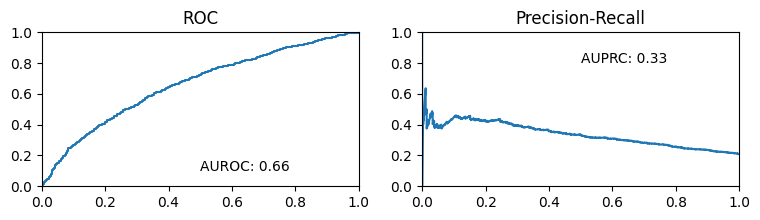

In [12]:
def prediction_fn(data):
    params = lr_model.sample(128)
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [13]:
if dataset == "ovarian":
    test_batch = next(iter(data_factory_factory(batch_size=56)()))
else:
    test_batch = next(iter(data_factory_factory()()))
param_test = lr_model.sample(128)


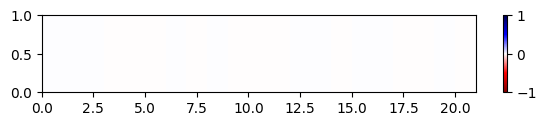

In [14]:
beta = tf.reduce_mean(param_test['beta__'], axis=0)
fig, ax = plt.subplots(1, 1, figsize=(7, 1 ))
im = ax.pcolormesh(beta, vmin=-1, vmax=1, cmap='seismic_r')
plt.colorbar(im)

In [32]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def adaptive_is_loo(self, data, params, hbar=1.0, variational=True):
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    beta = params["beta__"]
    intercept = params["intercept__"]
    X = tf.cast(data["X"], self.dtype)
    y = tf.cast(data["y"], self.dtype)[:, 0]
    mu = tf.reduce_sum(beta * X, axis=-1) + intercept[..., 0]
    sigma = tf.math.sigmoid(mu)
    ell = y * (sigma) + (1 - y) * (1 - sigma)
    log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
    log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)

    """
    sigma.shape is samples x datapoints
    """

    # compute # \nabla\log\pi(\btheta|\calD)
    if variational:
        # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
        grad_log_pi = tf.concat(
            [
                -(intercept - self.surrogate_distribution.model["intercept__"].mean())
                / self.surrogate_distribution.model["intercept__"].variance(),
                -(beta - self.surrogate_distribution.model["beta__"].mean())
                / self.surrogate_distribution.model["beta__"].variance(),
            ],
            axis=-1,
        )
        intercept_sd = (
            self.surrogate_distribution.model["intercept__"].variance() ** 0.5
        )
        beta_sd = self.surrogate_distribution.model["beta__"].variance() ** 0.5

        log_pi = self.surrogate_distribution.model["beta__"].log_prob(
            params["beta__"]
        ) + self.surrogate_distribution.model["intercept__"].log_prob(
            params["intercept__"]
        )
        log_pi -= tf.reduce_max(log_pi, axis=0)
        # log_pi.shape: [samples]
    else:
        """
        Recall Bayes rule:
        \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

        so
        \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

        """
        log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]
        log_pi += self.prior_distribution.log_prob(
            {
                "regression_model": {
                    k: tf.cast(params[k], self.dtype) for k in self.regression_var_list
                },
                "intercept_model": {
                    k: tf.cast(params[k], self.dtype) for k in self.intercept_var_list
                },
            }
        )
        # pi \propto
        grad_log_pi = tf.reduce_sum(
            log_ell[..., tf.newaxis] * X, axis=1, keepdims=True
        )  # TODO NEED PRIOR TERM

        prior_intercept_sd = (
            self.prior_distribution.model["intercept_model"]
            .model["intercept__"]
            .variance()
            ** 0.5
        )
        prior_beta_sd = params["global_scale"]

        intercept_sd = tf.math.reduce_std(intercept, 0, keepdims=True)
        beta_sd = tf.math.reduce_std(beta, 0, keepdims=True)

    # log-likelihood descent

    def T_ll():
        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized
        logJ = tf.math.log1p(
            tf.math.abs(
                h
                * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :]
                * (sigma * (1 - sigma))[..., tf.newaxis]
            )[..., 0]
        )
        beta_ll = beta + h * Q_beta
        intercept_ll = intercept + h * Q_intercept
        return beta_ll, intercept_ll, logJ

    def T_kl():

        Q_beta = ((-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ] * data["X"]
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(log_pi[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :]))
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + (1 - 2 * y)[:, tf.newaxis] * X), axis=-1
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept + h * Q_intercept
        beta_kl = beta + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    # variance descent -(log ell)'/l

    def T_I():
        Q = tf.zeros_like(log_ell)
        return (
            beta + Q[..., tf.newaxis],
            intercept + Q[..., tf.newaxis],
            tf.zeros_like(Q),
        )

    def T_var():

        Q_beta = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis] * data["X"]
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y[tf.newaxis, :]))
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + 2 * (1 - 2 * y)[:, tf.newaxis] * X),
                    axis=-1,
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept + h * Q_intercept
        beta_kl = beta + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def IS(Q):
        beta_new, intercept_new, logJ = Q()
        mu_new = tf.reduce_sum(beta_new * X, axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)
        transformed = params.copy()
        transformed["beta__"] = beta_new[..., tf.newaxis, :]
        transformed["intercept__"] = intercept_new[..., tf.newaxis, :]
        transformed["global_scale"] = transformed["global_scale"][..., tf.newaxis, :]
        transformed["global_scale_aux"] = transformed["global_scale_aux"][
            ..., tf.newaxis, :
        ]

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )
            pass
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = (
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * data["X"], -1)
                + intercept_new
            )
            ell_cross = tf.reduce_sum(
                ell_cross, -1
            )  # this is the likelihood portion of pi(T(theta))

            log_pi_new = self.prior_distribution.log_prob(
                {
                    "regression_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.regression_var_list
                    },
                    "intercept_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.intercept_var_list
                    },
                }
            )[:, tf.newaxis]
            log_pi_new += ell_cross
            log_pi_old = self.surrogate_distribution.log_prob(params)
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi_old[:, tf.newaxis]
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )

        log_eta_weights = delta_log_pi - log_ell_new + logJ
        psis_weights, khat = nppsis.psislw(log_eta_weights)
        
        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = self.entropy(eta_weights)
        psis_entropy = self.entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )

    (
        eta_ll,
        eta_ll_psis,
        p_loo_ll,
        p_loo_ll_sd,
        ll_loo_ll,
        ll_loo_ll_sd,
        S_ll,
        k_ll,
        p_psis_ll,
        ll_psis_ll,
    ) = IS(T_ll)
    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I)
    (
        eta_kl,
        eta_kl_psis,
        p_loo_kl,
        p_loo_kl_sd,
        ll_loo_kl,
        ll_loo_kl_sd,
        S_kl,
        k_kl,
        p_psis_kl,
        ll_psis_kl,
    ) = IS(T_kl)

    (
        eta_var,
        eta_var_psis,
        p_loo_var,
        p_loo_var_sd,
        ll_loo_var,
        ll_loo_var_sd,
        S_var,
        k_var,
        p_psis_var,
        ll_psis_var,
    ) = IS(T_var)

    # kl descent

    return {
        "I": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
        },
        "KL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_kl,
            "khat": k_kl,
            "p_psis": p_psis_kl,
            "ll_psis": ll_psis_kl,
        },
        "LL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_ll,
            "khat": k_ll,
            "p_psis": p_psis_ll,
            "ll_psis": ll_psis_ll,
        },
        "Var": {
            "p_loo": p_loo_var,
            "p_loo_sd": p_loo_var_sd,
            "ll_loo": ll_loo_var,
            "ll_loo_sd": ll_loo_var_sd,
            "S": S_var,
            "khat": k_var,
            "p_psis": p_psis_var,
            "ll_psis": ll_psis_var,
        },
    }


param_test = lr_model.sample(128)

loo = adaptive_is_loo(lr_model, test_batch, param_test, .5, variational=True)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.5: {np.sum(loo[T]['khat']>0.5)}"
    )

I: 0.02781195616880972 entropy: 25.8580395713917 khat>0.5: 0
LL: 0.028378594973154536 entropy: 24.58045883759995 khat>0.5: 33
KL: 0.028378594973154536 entropy: 25.842793844234063 khat>0.5: 0
Var: 0.028360153259405815 entropy: 25.842993123878202 khat>0.5: 0


In [33]:
loo['I']['khat']

array([-0.08507804, -0.14487211, -0.20214117, -0.29846278, -0.253866  ,
       -0.19827324, -0.52428735, -0.29500109, -0.29698813, -0.51378767,
       -0.46500352, -0.4134276 , -0.44650899, -0.47265676, -0.47436019,
       -0.48359274, -0.45691477, -0.47668899, -0.3934868 , -0.42676339,
       -0.43274502, -0.48416029, -0.43991197, -0.45577385, -0.48277779,
       -0.46569979, -0.47619027, -0.38464029, -0.3682163 , -0.4192697 ,
       -0.40951726, -0.50844597, -0.43776919, -0.41377107, -0.47269435,
       -0.45383705, -0.42474015, -0.40691449, -0.3870279 , -0.48666605,
       -0.38048503, -0.46963163, -0.46823637, -0.45304288, -0.36368553,
       -0.46289405, -0.47906147, -0.45622217, -0.45747473, -0.48850731,
       -0.47607384, -0.41637199, -0.46513015, -0.44651636, -0.47255537,
       -0.45395075, -0.43968954, -0.47716714, -0.45570863, -0.35840823,
       -0.51451864, -0.47799539, -0.37904986, -0.44269201, -0.45626547,
       -0.44346688, -0.41975063, -0.48563616, -0.46624362, -0.45

# Compute LOO AU ROC/PRC

In [17]:
step_size = 0.2
def prediction_fn_stepaway(data):
    params = lr_model.sample(100)
    loo = adaptive_is_loo(lr_model, data, params, step_size)
    return loo["KL"]['p_loo']

def prediction_fn_loo(data):
    params = lr_model.sample(100)
    pred = adaptive_is_loo(lr_model, data, params, step_size)["I"]['p_loo']
    return pred



In [18]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory_factory(batch_size=2000),
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory_factory(batch_size=2000),
    prediction_fn=prediction_fn_loo,
    outcome_label='y',
    by_vars=[]
)



0it [00:00, ?it/s]

2it [00:03,  1.78s/it]
2it [00:03,  1.77s/it]


Step-away LOO

(0.0, 1.0)

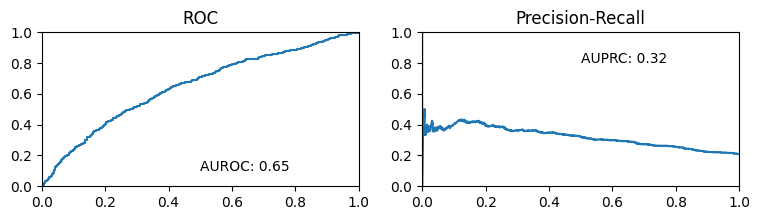

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_stepaway_loo['auroc']['fpr'], bench_stepaway_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_stepaway_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_stepaway_loo['auprc']['recall'], bench_stepaway_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_stepaway_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

LOO w/o stepaway

(0.0, 1.0)

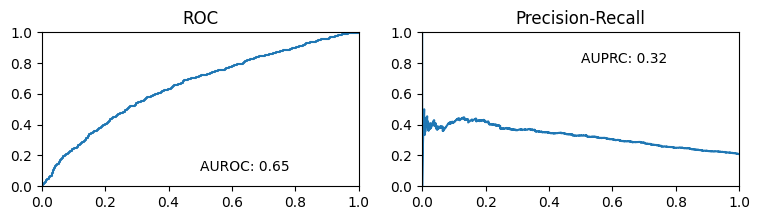

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

Training data metrics

In [21]:
bench['auroc']['auroc']

0.6617779106081114

In [22]:
params = lr_model.sample(200)
loo_out = []
for batch in tqdm(iter(data_factory_factory(batch_size=1000, repeat=False)())):
    loo_out += [adaptive_is_loo(lr_model, batch, params, 0.5, variational=True)]

0it [00:00, ?it/s]

4it [00:05,  1.26s/it]


In [23]:
loo_out[0].keys()

dict_keys(['I', 'KL', 'LL', 'Var'])

In [24]:
khat = {}
p_loo = {}
for method in ["I", "LL", "KL", "Var"]:
    khat[method] = np.concatenate([out[method]["khat"] for out in loo_out], axis=0)
    p_loo[method] = np.concatenate([out[method]["p_loo"] for out in loo_out], axis=0)

In [25]:
khat

{'I': array([-0.46032394, -0.24342604, -0.13924037, ..., -0.71075843,
        -0.69093236, -0.74820736]),
 'LL': array([0.22365886, 0.27699722, 0.30675537, ..., 0.61636462, 0.42301614,
        0.38903967]),
 'KL': array([-0.63712334, -0.36204   , -0.19170739, ..., -0.5152331 ,
        -0.35264897, -0.33138441]),
 'Var': array([-0.61151628, -0.35671787, -0.1887907 , ..., -0.51364966,
        -0.37813361, -0.33338133])}

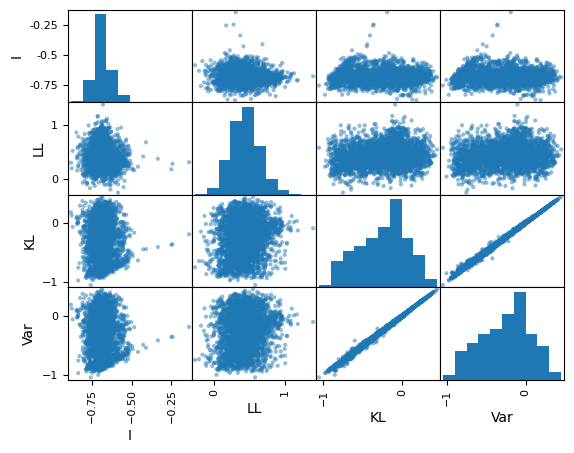

In [26]:
khat = pd.DataFrame(khat)
_ = pd.plotting.scatter_matrix(khat)


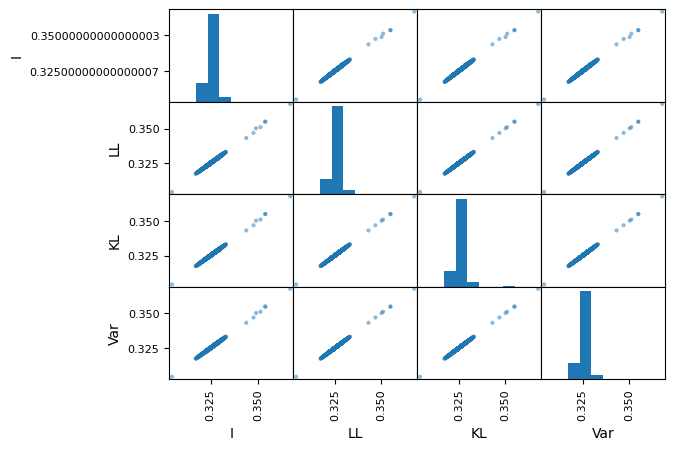

In [27]:
p_loo = pd.DataFrame(p_loo)
_ = pd.plotting.scatter_matrix(p_loo)

In [28]:
khat.describe()

,I,LL,KL,Var
count,3030.000000,3030.000000,3030.000000,3030.000000
mean,-0.684961,0.438062,-0.246477,-0.253038
std,0.056225,0.205359,0.311098,0.313110
min,-0.880724,-0.263333,-1.056880,-1.044584
25%,-0.719461,0.299448,-0.479838,-0.491903
50%,-0.690162,0.433187,-0.197288,-0.206933
75%,-0.655369,0.564699,-0.024809,-0.029411
max,-0.139240,1.388423,0.443585,0.446933


In [29]:
khat[khat.I > 0.5]

,I,LL,KL,Var


In [30]:
(khat>0.5).describe()

,I,LL,KL,Var
count,3030,3030,3030,3030
unique,1,2,1,1
top,False,False,False,False
freq,3030,1899,3030,3030
